In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import f1_score, roc_curve, auc
import seaborn as sns

In [13]:
dataset_path = r'C:\Jupyter Notebook\UOB labs\DSMP\Sapienza_data\progetto_bristol\dataset'
model_path = r'C:\Jupyter Notebook\UOB labs\DSMP\Sapienza_data\progetto_bristol\models\my_model.keras'
model = load_model(model_path)

In [15]:
def read_and_norm(dataset_path, type_, file_name):
    with open(f'{dataset_path}/{type_}/{file_name}.txt', 'rb') as f:
        matrix = [[float(x) for x in line.split()] for line in f]
    matrix = np.array(matrix)
    min_m, max_m = matrix.min().min(), matrix.max().max()
    return (matrix - min_m) / (max_m - min_m)

def load_test_dataset(dataset_path):
    classification = np.loadtxt(f'{dataset_path}/test/classification.txt').reshape(-1,1)

    with open(f'{dataset_path}/test/hr.txt', "r") as file:
        hr = [list(map(float, line.split())) for line in file if len(line.split()) != 9]
    hr = np.array(hr)

    shape = read_and_norm(dataset_path, 'test', 'shape')
    el = read_and_norm(dataset_path, 'test', 'el')
    dist = read_and_norm(dataset_path, 'test', 'dist')

    # Ensure dimensions match
    data_X = np.array([p for p in zip(shape, dist, el, hr)])
    data_X = data_X.reshape(data_X.shape[0], data_X.shape[1], data_X.shape[2], 1)

    return data_X, classification

testX, testy = load_test_dataset(dataset_path)


In [17]:
pred_probs = model.predict(testX)

41/41 [==============================] - 0s 2ms/step


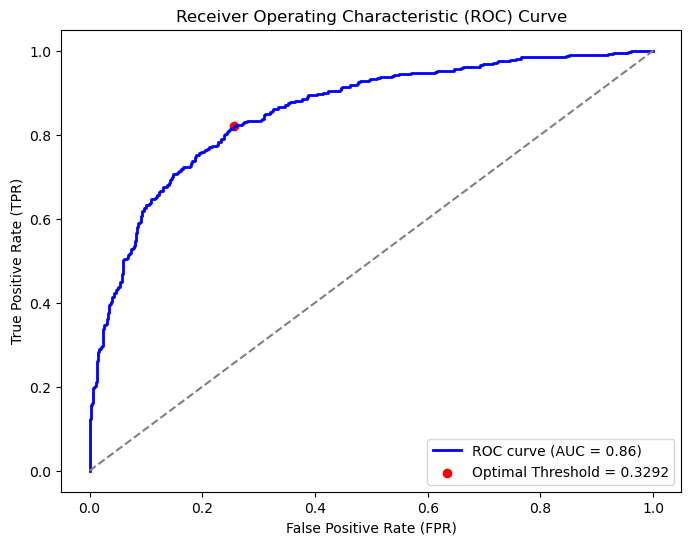

Optimal Threshold: 0.3292


In [19]:
# True labels (from test dataset)
true_labels = testy  # testy = ground truth labels

# Predicted probabilities from the model
predicted_probs = pred_probs  # pred_probs contains probability scores

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Compute Youden’s J statistic to find the best threshold
J_scores = tpr - fpr  # Youden's J = TPR - FPR
optimal_idx = np.argmax(J_scores)  # Find index where J is max
optimal_threshold = thresholds[optimal_idx]

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the optimal threshold
print(f"Optimal Threshold: {optimal_threshold:.4f}")


In [21]:
pred_labels = (pred_probs >= optimal_threshold).astype(int)

# Evaluate accuracy
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(testy, pred_labels)
f1 = f1_score(testy, pred_labels)

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final F1-Score: {f1:.4f}")


Final Accuracy: 0.7816
Final F1-Score: 0.7869


In [23]:
# Convert probability predictions into binary classes
final_predictions = (pred_probs >= optimal_threshold).astype(int)

# Save results for analysis
results_df = pd.DataFrame({'True_Label': testy.reshape(-1), 'Predicted_Label': final_predictions.reshape(-1), 'Probability': pred_probs.reshape(-1)})

# Save to CSV
results_df.to_csv("prediction_results.csv", index=False)

print("Predictions saved to prediction_results.csv")

Predictions saved to prediction_results.csv


In [25]:
# Define residue type dictionary
residue_dict = {
    'GLY': 'H', 'ALA': 'H', 'VAL': 'H', 'LEU': 'H', 'ILE': 'H', 'MET': 'H', 'PHE': 'H', 'TYR': 'H', 'TRP': 'H',
    'SER': 'P', 'PRO': 'P', 'THR': 'P', 'CYS': 'P', 'ASN': 'P', 'GLN': 'P',
    'HIS': 'C', 'LYS': 'C', 'ARG': 'C', 'ASP': 'C', 'GLU': 'C'
}

# Load dataset (skip the first row since it's a header)
dataset_path = r'C:\Jupyter Notebook\UOB labs\DSMP\Sapienza_data\progetto_bristol\dataset\test\dataset.txt'
df = pd.read_csv(dataset_path)

# Extract relevant columns: resA and resB
residue_A = df["resA"].values  # First protein residue
residue_B = df["resB"].values  # Second protein residue

# Map residues to their types
residue_A_types = np.array([residue_dict.get(res, 'Unknown') for res in residue_A])
residue_B_types = np.array([residue_dict.get(res, 'Unknown') for res in residue_B])

# Add classified types back to the DataFrame
df["resA_type"] = residue_A_types
df["resB_type"] = residue_B_types

# Save the processed file (optional)
df.to_csv("classified_dataset.csv", index=False)

# Print first few rows
print(df.head())

    pdb resA resB resB_1 resB_2 resB_3 resB_4 resB_5 resB_6 resB_7 resB_8  \
0  1K6D  HIS  HIS    THR    GLN    ASP    LEU    ILE    PRO    TYR    VAL   
1  1KAM  GLU  GLY    PRO    SER    GLU    PHE    LEU    TYR    THR    GLU   
2  2GED  PHE  VAL    ILE    SER    LEU    VAL    ASP    GLU    PHE    ILE   
3  3HL6  GLU  LYS    LEU    LEU    ALA    ARG    GLU    GLU    LEU    ASP   
4  3QQ8  GLY  THR    GLU    ARG    PHE    THR    ARG    GLN    PHE    SER   

  resB_9 resA_type resB_type  
0    ARG         C         C  
1    ARG         C         H  
2    GLU         H         H  
3    ASP         C         C  
4    LEU         H         P  


In [27]:
results_df = pd.read_csv("prediction_results.csv")
print(results_df.head())  # Check column names
print(results_df.columns)  # Print all column names


   True_Label  Predicted_Label  Probability
0         1.0                0     0.050524
1         0.0                0     0.110214
2         0.0                1     0.891358
3         0.0                1     0.379980
4         1.0                1     0.497577
Index(['True_Label', 'Predicted_Label', 'Probability'], dtype='object')


Optimal Threshold (Youden's J): 0.3292
              F1-score
Residue Pair          
C-C           0.454545
C-H           0.645161
H-H           0.914373
H-P           0.685714
P-C           0.478261
P-P           0.709091
P-H           0.853147
H-C           0.506329
C-P           0.500000


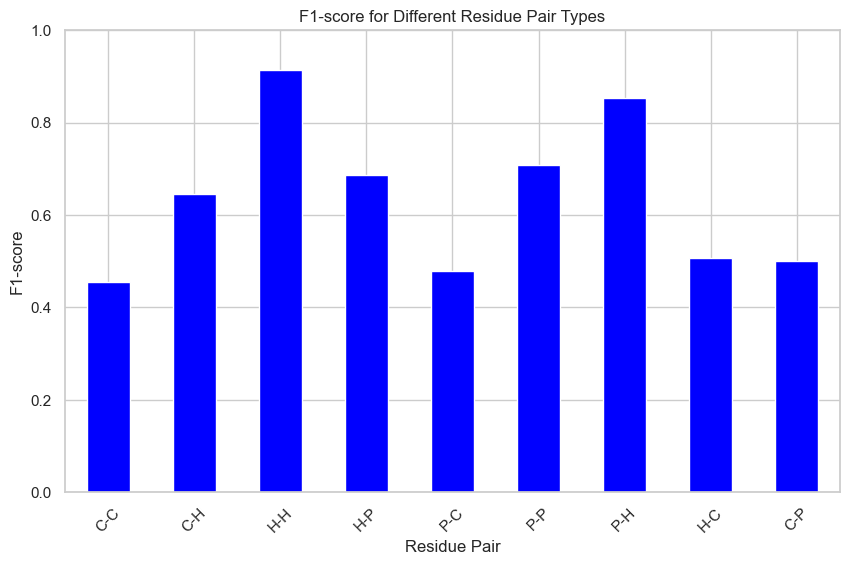

In [29]:
# Load classified dataset
classified_df = pd.read_csv("classified_dataset.csv")

# Load model predictions (ensure it has probability scores)
results_df = pd.read_csv("prediction_results.csv")

# Merge the datasets based on index
df = pd.concat([classified_df, results_df], axis=1)

# Ensure required columns exist
df = df[['resA', 'resB', 'resA_type', 'resB_type', 'True_Label', 'Probability']]

# Create residue pair type (e.g., "H-H", "H-P")
df["residue_pair"] = df["resA_type"] + "-" + df["resB_type"]

# Extract true labels and predicted probabilities
true_labels = df["True_Label"].values
predicted_probs = df["Probability"].values

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Compute Youden’s J statistic to find the best threshold
J_scores = tpr - fpr
optimal_idx = np.argmax(J_scores)
optimal_threshold = thresholds[optimal_idx]

# Convert probabilities to binary predictions using the optimal threshold
df["Predicted_Label"] = (df["Probability"] >= optimal_threshold).astype(int)

# Print the optimal threshold
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

# Function to compute F1-score for residue pairs
def compute_f1(residue_pair):
    subset = df[df["residue_pair"] == residue_pair]  # Filter by residue pair type
    if subset.empty:
        return np.nan  # Return NaN if no samples for this pair type
    
    y_true = subset["True_Label"]
    y_pred = subset["Predicted_Label"]
    
    return f1_score(y_true, y_pred, zero_division=0)

# Get unique residue pairs and compute F1-scores
residue_pairs = df["residue_pair"].unique()
f1_scores = {pair: compute_f1(pair) for pair in residue_pairs}

# Convert to DataFrame
f1_df = pd.DataFrame(f1_scores.items(), columns=["Residue Pair", "F1-score"]).set_index("Residue Pair")

# Print results
print(f1_df)

# Plot F1-score per residue pair
sns.set(style="whitegrid")
f1_df.plot(kind="bar", figsize=(10, 6), color="blue", legend=False)
plt.title("F1-score for Different Residue Pair Types")
plt.ylabel("F1-score")
plt.ylim(0, 1)  # Keep values between 0 and 1
plt.xticks(rotation=45)
plt.show()
